# Урок 1. Введение в спортивный анализ данных, Exploration Data Analysis.

### Домашнее задание 1:

**[Задание 1](#task1):** Сделать базовый анализ данных: вывести размерность датасетов, посчитать базовые статистики, выполнить анализ пропусков, сделать выводы;

**[Задание 2](#task2):** Сделать базовый анализ целевой переменной, сделать выводы;

**[Задание 3](#task3):** Построить распределение признаков в зависимости от значения целевой переменной и распределение признаков для обучающей и тестовой выборки (если машина не позволяет построить распределение для всех признаков, то выполнить задание для признаков var_0, var_1, var_2, var_5, var_9, var_10, var_13, var_20, var_26, var_40, var_55, var_80, var_106, var_109, var_139, var_175, var_184, var_196), сделать выводы;

**[Задание 4](#task4):** Построить распределение основных статистики признаков (среднее, стандартное отклонение) в разрезе целевой переменной и распределение основных статистик обучающей и тестовой выборки, сделать выводы;

**[Задание 5](#task5):** Построить распределение коэффициентов корреляции между признаками. Есть ли зависимость между признаками (будем считать, что связь между признаками отсутствует, если коэффициент корреляции < 0.2)?

**[Задание 6](#task6):** Выявить 10 признаков, которые обладают наибольшей нелинейной связью с целевой переменной.

**[Задание 7](#task7) (опция):** Провести анализ идентичности распределения признаков на обучающей и тестовой выборках, сделать выводы.

Ссылка на наборы данных: https://drive.google.com/file/d/1j8zuKbI-PW5qKwhybP4S0EtugbPqmeyX/view?usp=sharing

p.s. это обязательная программа для выполнения домашки, вы можете расширить эту программу и сделать больше; я только за :)

#!pip install missingno    # Missingo предлагает быстрый и простой способ по визуализации отсутствующих значений.

**Подключение библиотек и скриптов**

In [1]:
from typing import List, Optional
from tqdm import tqdm

import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt

import seaborn as sns
import scipy.stats as st
from scipy.stats import probplot, ks_2samp

from sklearn.metrics import roc_auc_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import KFold, cross_val_score
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.utils.validation import check_is_fitted

import missingno as msno  # Missingo предлагает быстрый и простой способ по визуализации отсутствующих значений.

import xgboost as xgb

%matplotlib inline

In [2]:
def reduce_mem_usage(df):
    '''Сокращение размера датафрейма за счёт изменения типа данных'''
    
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df

**Пути к директориям и файлам**

In [3]:
# input
TRAIN_DATASET_PATH = './data/train.csv'
TEST_DATASET_PATH = './data/test.csv'

# output
#PREP_DATASET_PATH = './assignment1_data/data_prep.csv'

**Загрузка данных**

In [4]:
# Тренировочные данные
train = pd.read_csv(TRAIN_DATASET_PATH)
df_train =reduce_mem_usage(train)
# Тестовые данные
test = pd.read_csv(TEST_DATASET_PATH)
df_train =reduce_mem_usage(test)

Memory usage of dataframe is 308.23 MB
Memory usage after optimization is: 160.07 MB
Decreased by 48.1%
Memory usage of dataframe is 306.70 MB
Memory usage after optimization is: 159.88 MB
Decreased by 47.9%


## Задание 1 (Базовый анализ данных):<a class="anchor" id="task1"></a>

Сделать базовый анализ данных: вывести размерность датасетов, посчитать базовые статистики, выполнить анализ пропусков, сделать выводы;

---

**Размерности датасетов**

In [5]:
print("train.shape = {} rows, {} cols".format(*train.shape))
print("test.shape = {} rows, {} cols".format(*test.shape))

train.shape = 200000 rows, 202 cols
test.shape = 200000 rows, 201 cols


---

In [6]:
categorical_features = train.select_dtypes(include=[np.object])
print(f"Categorical Feature Count {categorical_features.shape[1]}")
categorical_features.head(n=2)
# ID_code - поле идентификатор

Categorical Feature Count 0


Empty DataFrame
Columns: []
Index: [0, 1]

In [7]:
#train_num_features = train.select_dtypes(include=['float32', 'float64', 'int8', 'int16', 'int32', 'int64'])
#train_num_features

**Тренировочный датасет**

In [8]:
train.info()
# Типы полей (dtypes): float64(200), int64(1), object(1)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200000 entries, 0 to 199999
Columns: 202 entries, ID_code to var_199
dtypes: category(1), float32(200), int8(1)
memory usage: 160.1 MB


In [9]:
train.dtypes

ID_code    category
target         int8
var_0       float32
var_1       float32
var_2       float32
             ...   
var_195     float32
var_196     float32
var_197     float32
var_198     float32
var_199     float32
Length: 202, dtype: object

In [10]:
train.head()

ID_code  target    var_0   var_1    var_2   var_3    var_4   var_5   var_6  \
0  train_0       0   8.9255 -6.7863  11.9081  5.0930  11.4607 -9.2834  5.1187   
1  train_1       0  11.5006 -4.1473  13.8588  5.3890  12.3622  7.0433  5.6208   
2  train_2       0   8.6093 -2.7457  12.0805  7.8928  10.5825 -9.0837  6.9427   
3  train_3       0  11.0604 -2.1518   8.9522  7.1957  12.5846 -1.8361  5.8428   
4  train_4       0   9.8369 -1.4834  12.8746  6.6375  12.2772  2.4486  5.9405   

     var_7  ...  var_190  var_191  var_192  var_193    var_194  var_195  \
0  18.6266  ...   4.4354   3.9642   3.1364   1.6910  18.522699  -2.3978   
1  16.5338  ...   7.6421   7.7214   2.5837  10.9516  15.430500   2.0339   
2  14.6155  ...   2.9057   9.7905   1.6704   1.6858  21.604200   3.1417   
3  14.9250  ...   4.4666   4.7433   0.7178   1.4214  23.034700  -1.2706   
4  19.2514  ...  -1.4905   9.5214  -0.1508   9.1942  13.287600  -1.5121   

   var_196  var_197    var_198  var_199  
0   7.8784   8.5635  12.780300  -1.0914  
1   8.1267   8.7889  18.356001   1.9518  
2  -6.5213   8.2675  14.722200   0.3965  
3  -2.9275  10.2922  17.969700  -8.9996  
4   3.9267   9.5031  17.997400  -8.8104  

[5 rows x 202 columns]

**Тестовый датасет**

In [11]:
test.info()
# Типы полей (dtypes): float64(200), object(1)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200000 entries, 0 to 199999
Columns: 201 entries, ID_code to var_199
dtypes: category(1), float32(200)
memory usage: 159.9 MB


In [12]:
test.dtypes

ID_code    category
var_0       float32
var_1       float32
var_2       float32
var_3       float32
             ...   
var_195     float32
var_196     float32
var_197     float32
var_198     float32
var_199     float32
Length: 201, dtype: object

In [13]:
test.head()

ID_code    var_0    var_1    var_2   var_3    var_4   var_5   var_6  \
0  test_0  11.0656   7.7798  12.9536  9.4292  11.4327 -2.3805  5.8493   
1  test_1   8.5304   1.2543  11.3047  5.1858   9.1974 -4.0117  6.0196   
2  test_2   5.4827 -10.3581  10.1407  7.0479  10.2628  9.8052  4.8950   
3  test_3   8.5374  -1.3222  12.0220  6.5749   8.8458  3.1744  4.9397   
4  test_4  11.7058  -0.1327  14.1295  7.7506   9.1035 -8.5848  6.8595   

       var_7   var_8  ...  var_190  var_191  var_192  var_193    var_194  \
0  18.267500  2.1337  ...  -2.1556  11.8495  -1.4300   2.4508  13.711200   
1  18.631599 -4.4131  ...  10.6165   8.8349   0.9403  10.1282  15.576500   
2  20.253700  1.5233  ...  -0.7484  10.9935   1.9803   2.1800  12.981300   
3  20.566000  3.3755  ...   9.5702   9.0766   1.6580   3.5813  15.187400   
4  10.604800  2.9890  ...   4.2259   9.1723   1.2835   3.3778  19.554199   

   var_195  var_196  var_197    var_198    var_199  
0   2.4669   4.3654  10.7200  15.472200  -8.719700  
1   0.4773  -1.4852   9.8714  19.129299 -20.976000  
2   2.1281  -7.1086   7.0618  19.895599 -23.179399  
3   3.1656   3.9567   9.2295  13.016800  -4.210800  
4  -0.2860  -5.1612   7.2882  13.926000  -9.184600  

[5 rows x 201 columns]

**Базовые статистики**

In [14]:
# Тренировочный датасет
train.describe().T

count       mean        std        min        25%       50%  \
target   200000.0   0.100490   0.300653   0.000000   0.000000   0.00000   
var_0    200000.0  10.679973   3.039990   0.408400   8.453850  10.52475   
var_1    200000.0  -1.627628   4.049967 -15.043400  -4.740025  -1.60805   
var_2    200000.0  10.715126   2.640832   2.117100   8.722475  10.58000   
var_3    200000.0   6.796523   2.043276  -0.040200   5.254075   6.82500   
...           ...        ...        ...        ...        ...       ...   
var_195  200000.0  -0.142087   1.429341  -5.261000  -1.170700  -0.17270   
var_196  200000.0   2.303355   5.454274 -14.209600  -1.946925   2.40890   
var_197  200000.0   8.908224   0.921603   5.960600   8.252800   8.88820   
var_198  200000.0  15.870864   3.010892   6.299300  13.829700  15.93405   
var_199  200000.0  -3.326542  10.437832 -38.852798 -11.208475  -2.81955   

               75%        max  
target    0.000000   1.000000  
var_0    12.758200  20.315001  
var_1     1.358625  10.376800  
var_2    12.516700  19.353001  
var_3     8.324100  13.188300  
...            ...        ...  
var_195   0.829600   4.272900  
var_196   6.556725  18.321501  
var_197   9.593300  12.000400  
var_198  18.064724  26.079100  
var_199   4.836800  28.500700  

[201 rows x 8 columns]

In [15]:
# Тестовый датасет
test.describe().T

count       mean        std        min        25%       50%  \
var_0    200000.0  10.658732   3.036675   0.188700   8.442975  10.51380   
var_1    200000.0  -1.624240   4.040431 -15.043400  -4.700125  -1.59050   
var_2    200000.0  10.707497   2.633820   2.355200   8.735600  10.56070   
var_3    200000.0   6.788238   2.052685  -0.022400   5.230500   6.82235   
var_4    200000.0  11.076387   1.616426   5.484400   9.891075  11.09975   
...           ...        ...        ...        ...        ...       ...   
var_195  200000.0  -0.133656   1.429652  -4.911900  -1.160700  -0.16200   
var_196  200000.0   2.290916   5.446252 -13.944200  -1.948600   2.40360   
var_197  200000.0   8.912555   0.920886   6.169600   8.260075   8.89280   
var_198  200000.0  15.869393   3.008664   6.584000  13.847275  15.94340   
var_199  200000.0  -3.246347  10.398454 -39.457802 -11.124000  -2.72595   

               75%        max  
var_0    12.739600  22.323400  
var_1     1.343400   9.385100  
var_2    12.495025  18.714100  
var_3     8.327600  13.142000  
var_4    12.253400  16.037100  
...            ...        ...  
var_195   0.837900   4.545400  
var_196   6.519800  15.920700  
var_197   9.595900  12.275800  
var_198  18.045200  26.538401  
var_199   4.935400  27.907400  

[200 rows x 8 columns]

### Анализ пропусков

**Вывод:** Поля имеющие пропуски отсутствуют

Visualizing missing value using matrix


<AxesSubplot:>

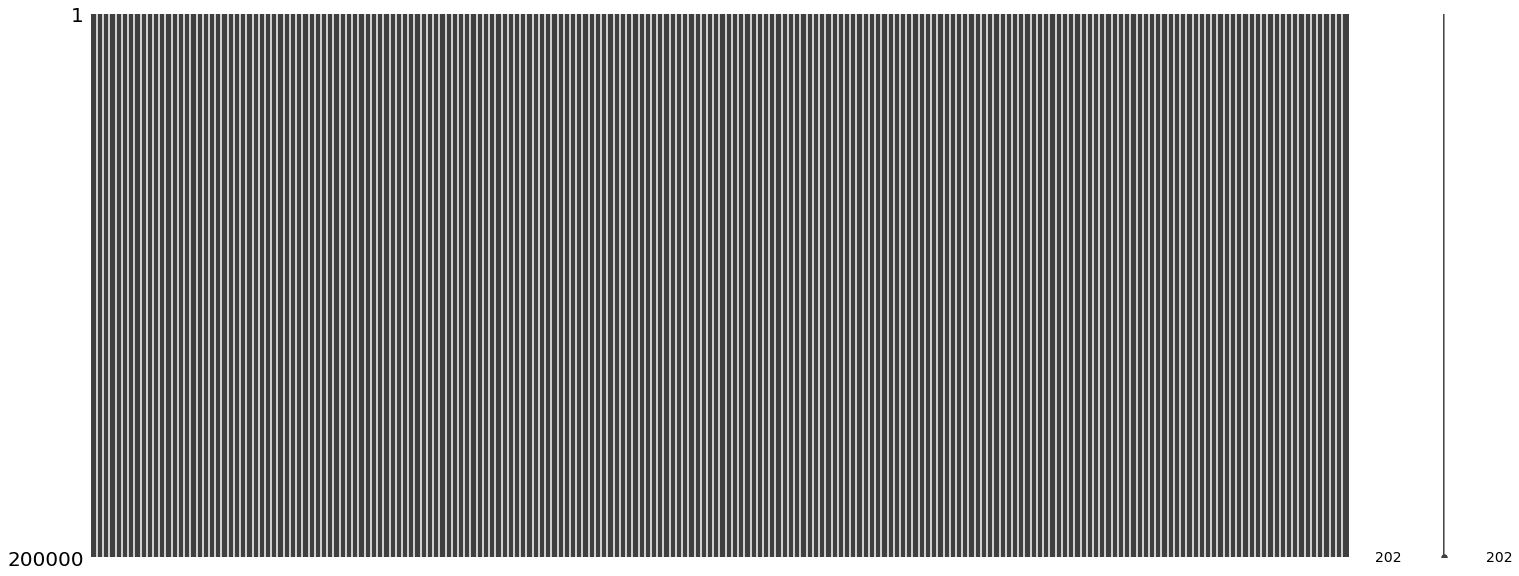

In [16]:
# Визуализировать пропущенные значения в виде матрицы

print('Visualizing missing value using matrix')
msno.matrix(train)

In [17]:
# Визуализировать количество пропущенные значения в виде гистограммы

print('Visualizing missing value using bar graph')
#msno.bar(train, labels=True)

Visualizing missing value using bar graph


In [18]:
# Тепловая карта : Тепловая карта показывает корреляцию отсутствующих значений между каждыми 2 столбцами.

#msno.heatmap(train)

In [19]:
train.isnull().sum() 

ID_code    0
target     0
var_0      0
var_1      0
var_2      0
          ..
var_195    0
var_196    0
var_197    0
var_198    0
var_199    0
Length: 202, dtype: int64

In [20]:
# Тренировочный датасет

# Выводим список полей имеющих пропуски
i = 0
for j in train:
    if train[j].isnull().sum() !=0 :
        print(j)
        i += 1
        
print(f'Количество полей имеющих пропуски: {i}')
        
# Поля имеющие пропуски отсутствуют

Количество полей имеющих пропуски: 0


In [21]:
# Выводим список полей не имеющих пропуски
i = 0
for j in train:
    if train[j].isnull().sum() == 0 :
        print(j)
        i += 1

print(f'Количество полей не имеющих пропуски: {i}')

ID_code
target
var_0
var_1
var_2
var_3
var_4
var_5
var_6
var_7
var_8
var_9
var_10
var_11
var_12
var_13
var_14
var_15
var_16
var_17
var_18
var_19
var_20
var_21
var_22
var_23
var_24
var_25
var_26
var_27
var_28
var_29
var_30
var_31
var_32
var_33
var_34
var_35
var_36
var_37
var_38
var_39
var_40
var_41
var_42
var_43
var_44
var_45
var_46
var_47
var_48
var_49
var_50
var_51
var_52
var_53
var_54
var_55
var_56
var_57
var_58
var_59
var_60
var_61
var_62
var_63
var_64
var_65
var_66
var_67
var_68
var_69
var_70
var_71
var_72
var_73
var_74
var_75
var_76
var_77
var_78
var_79
var_80
var_81
var_82
var_83
var_84
var_85
var_86
var_87
var_88
var_89
var_90
var_91
var_92
var_93
var_94
var_95
var_96
var_97
var_98
var_99
var_100
var_101
var_102
var_103
var_104
var_105
var_106
var_107
var_108
var_109
var_110
var_111
var_112
var_113
var_114
var_115
var_116
var_117
var_118
var_119
var_120
var_121
var_122
var_123
var_124
var_125
var_126
var_127
var_128
var_129
var_130
var_131
var_132
var_133
var_134
var_135
var_136

In [22]:
# Тестовый датасет
# Выводим список полей имеющих пропуски

i = 0
for j in test:
    if test[j].isnull().sum() !=0 :
        print(j)
        i += 1
        
print(f'Количество полей имеющих пропуски: {i}')
        
# Поля имеющие пропуски отсутствуют

Количество полей имеющих пропуски: 0


### Вывод (Задание 1)

**Размерность датасетов**
- Количество строк в тренировочном датасете: **200000**
- Количество столбцов в тренировочном датасете: **202**, из них **200** - признаки, поле **ID_code** - идентификатор, **target** - целевой столбец
- Количество строк в тестовом датасете: **200000**
- Количество столбцов в тестовом датасете: **201**, из них **200** - признаки, поле **ID_code** - идентификатор

**Базовые статистики**

Типы данных (на примере train)
- Columns: 202 entries, ID_code to var_199
- dtypes: float64(200), int64(1), object(1)

**Анализ пропусков**
- В тренировочном датасете поля имеющие пропуски **отсутствуют**
- В тестовом датасете поля имеющие пропуски **отсутствуют**

## Задание 2 (Анализ распределения целевой переменной):<a class="anchor" id="task2"></a> 

Сделать базовый анализ целевой переменной, сделать выводы;

### Обзор целевой переменной

In [23]:
train['target'].value_counts()  # Количество различных значений признака 'target'

0    179902
1     20098
Name: target, dtype: int64

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


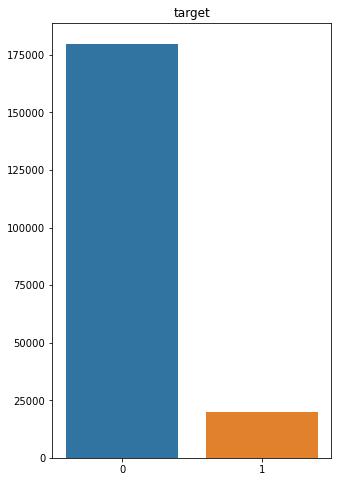

In [24]:
counts = train['target'].value_counts()
    
plt.figure(figsize=(5,8))    
plt.title('target')
sns.barplot(counts.index, counts.values)
    
plt.show()

**Вывод:** 
- Целевая переменная имеет два значения 0 и 1. следовательно перед нами задача классификации;
- Наблюдается дисбаланс классов, поэтому перед построением модели нужно будет произвести балансировку классов одним из методов. 

## Задание 3:<a class="anchor" id="task3"></a>

Построить распределение признаков в зависимости от значения целевой переменной и распределение признаков для обучающей и тестовой выборки (если машина не позволяет построить распределение для всех признаков, то выполнить задание для признаков var_0, var_1, var_2, var_5, var_9, var_10, var_13, var_20, var_26, var_40, var_55, var_80, var_106, var_109, var_139, var_175, var_184, var_196), сделать выводы;

**Анализ числовых признаков (Непрерывные признаки)**

**Распределение признаков в зависимости от значения целевой переменной**

In [25]:
#grid = sns.jointplot(train['target'], train['var_0'], kind='kde')
#grid = sns.jointplot(train['target'], train['var_0'], kind='reg')
#grid.fig.set_figwidth(8)
#grid.fig.set_figheight(8)

#plt.show()

In [26]:
#grid = sns.jointplot(train['target'], train['var_1'], kind='kde')
#grid.fig.set_figwidth(8)
#grid.fig.set_figheight(8)

#plt.show()

**Распределение признаков для обучающей и тестовой выборки**

In [27]:
#numerical_features = train.select_dtypes(include=[np.number])
#print(f"count of numeric_features {numerical_features.shape[1]}")

#numerical_features.columns

In [28]:
numerical_features = ['var_0', 'var_1', 'var_2', 'var_5', 'var_9', 'var_10', 'var_13', 'var_20', 'var_26', 'var_40',
                      'var_55', 'var_80', 'var_106', 'var_109', 'var_139', 'var_175', 'var_184', 'var_196']

**Обучающая выборка**

In [29]:
train_num_features = []

In [30]:
train_num_features = train[numerical_features]
print(f"Continuous Feature Count {len(numerical_features)}")

Continuous Feature Count 18


In [31]:
train_num_features.head(n=2)

var_0   var_1    var_2   var_5   var_9  var_10  var_13   var_20   var_26  \
0   8.9255 -6.7863  11.9081 -9.2834  5.7470  2.9252  0.5745  10.5350  -5.1488   
1  11.5006 -4.1473  13.8588  7.0433  8.0851 -0.4032  8.4135   3.4287 -11.7684   

    var_40     var_55   var_80  var_106  var_109    var_139  var_175  var_184  \
0  -5.2387  14.832200  13.6468   9.5426  24.3627  15.659900   7.7423  25.8398   
1 -11.1147  18.599501   2.5462   7.3412  13.0858  16.162201  10.4968  22.5441   

   var_196  
0   7.8784  
1   8.1267

Для непрерывные признаков имеет смысл строить гистрограммы распределения или функции распределения,
а также зависимость непрерывного признака в разрезе целевой переменной.

Кроме того, имеет смысл строить распределение __одновременно__ и для обучающей выборки, и для тестовой для понимания насколько отличаются распределения.

In [32]:
#train_num_features.hist(figsize=(16, 16), bins=20, grid=False)

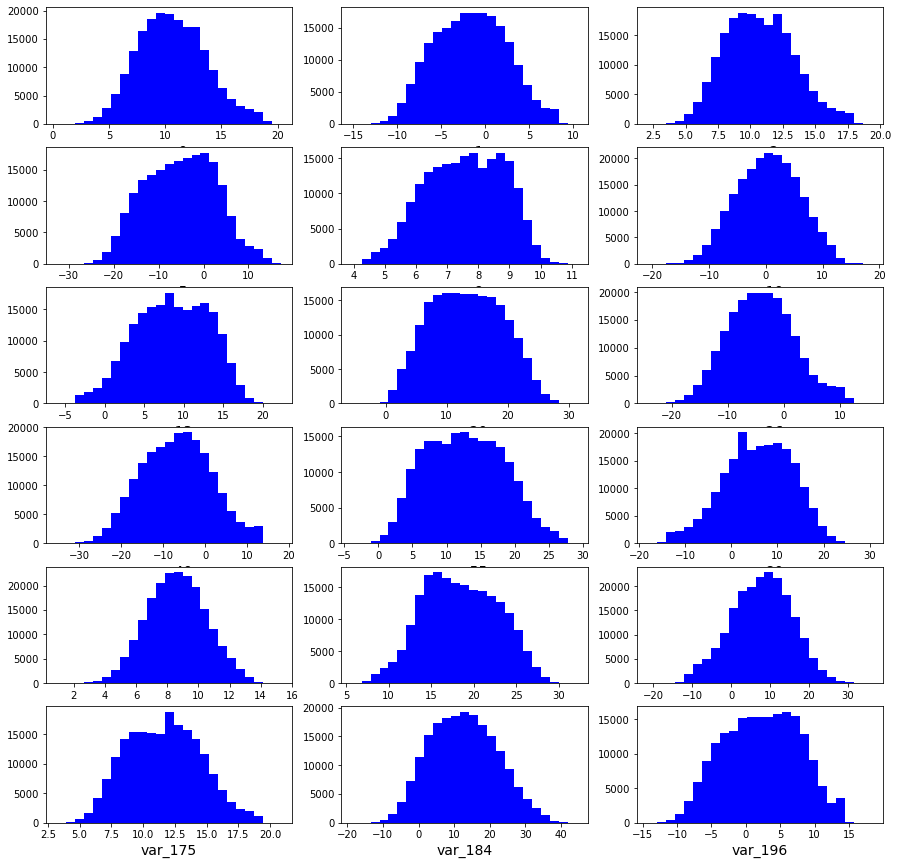

In [33]:
fig, axes = plt.subplots(6, 3, figsize=(15, 15))

for num, feature in enumerate(numerical_features):
    data = train_num_features[feature].copy()
    axes[num//3, num%3].hist(data, bins=25, color="blue")
    axes[num//3, num%3].set_xlabel(feature, fontsize=14)

**Тестовая выборка**

In [34]:
test_num_features = test[numerical_features]
print(f"Continuous Feature Count {len(numerical_features)}")

Continuous Feature Count 18


In [35]:
test_num_features.head(n=2)

var_0   var_1    var_2   var_5   var_9  var_10  var_13   var_20  var_26  \
0  11.0656  7.7798  12.9536 -2.3805  8.8100 -2.0248  0.3458   3.7088 -9.4902   
1   8.5304  1.2543  11.3047 -4.0117  5.9739 -1.3809  2.5667  12.1469 -5.2341   

    var_40     var_55  var_80  var_106    var_109  var_139  var_175  \
0 -15.6305  16.636499  9.4883   8.2856  15.076300  -2.5502  12.2818   
1  10.0309  16.423901  1.9772   6.4986  17.726101   6.7530   9.6083   

     var_184  var_196  
0  31.352100   4.3654  
1  25.195801  -1.4852

In [36]:
#test_num_features.hist(figsize=(16, 16), bins=20, grid=False)

In [37]:
#fig, axes = plt.subplots(6, 3, figsize=(15, 15))

#for num, feature in enumerate(numerical_features):
#    data = test_num_features[feature].copy()
#    axes[num//3, num%3].hist(data, bins=25, color="blue")
#    axes[num//3, num%3].set_xlabel(feature, fontsize=14)

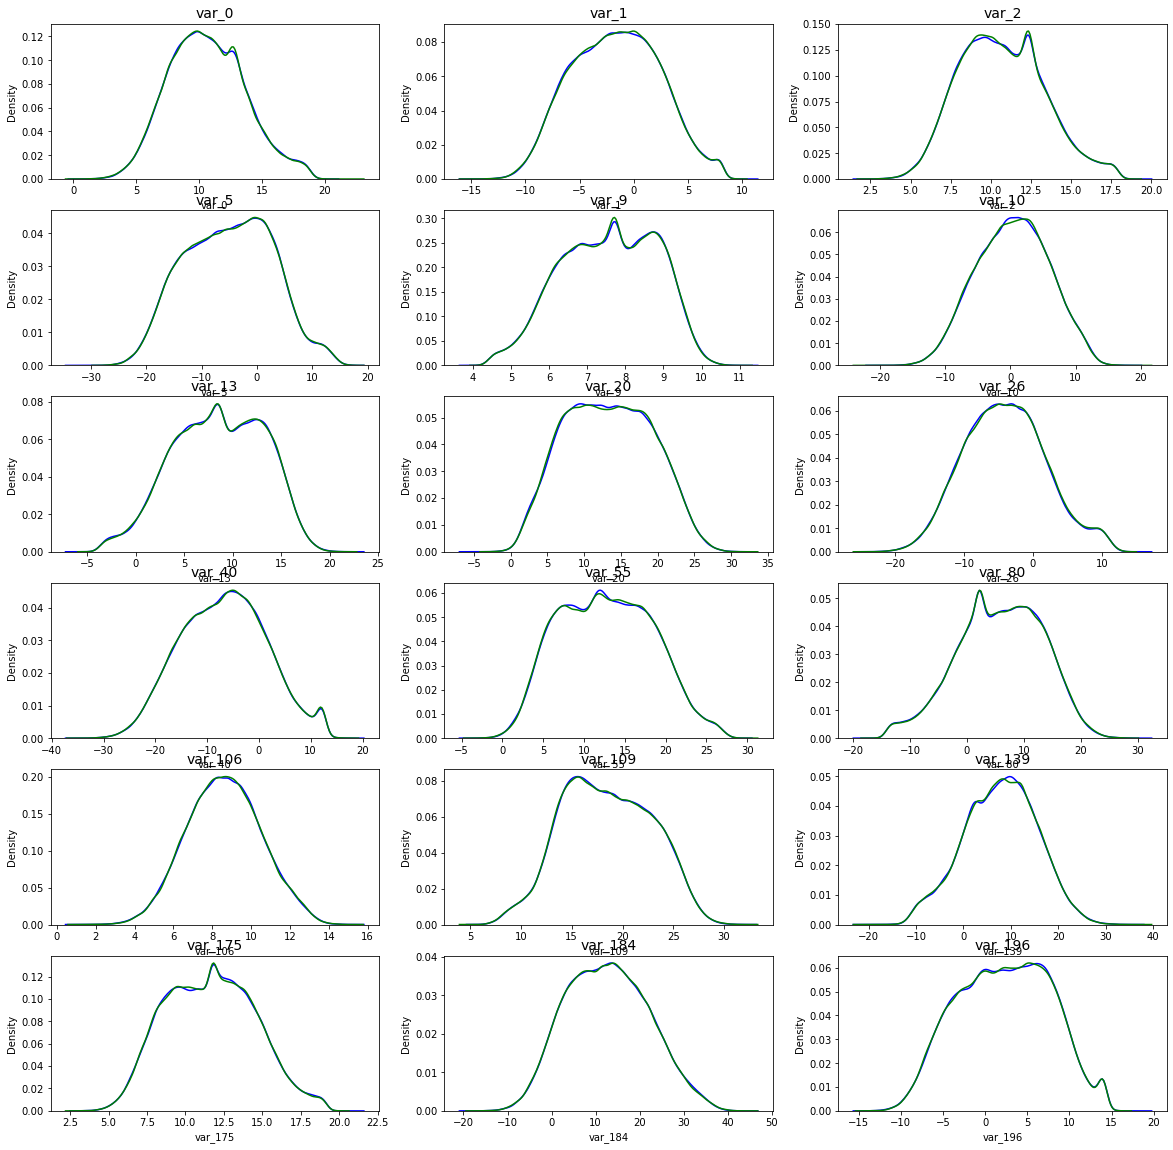

In [38]:
fig, axes = plt.subplots(6, 3, figsize=(20, 20))

for num, feature in enumerate(numerical_features):
    try:
        train_data, test_data = train[feature].copy(), test[feature].copy()
        sns.kdeplot(train_data, ax=axes[num//3, num%3], color="blue", label="train")
        sns.kdeplot(test_data, ax=axes[num//3, num%3], color="green", label="test")
    except RuntimeError:
        pass
    except KeyError:
        train_data = train[feature].copy()
        sns.kdeplot(train_data, ax=axes[num//3, num%3], color="blue", label="train")
    axes[num//3, num%3].set_title(feature, fontsize=14)

**Вывод:** 
- распределение обучающей и тестовой выборок очень похожы
- распределения не распределены нормально (?)
- имеются аномалии и выбросы


## Задание 4:<a class="anchor" id="task4"></a>

Построить распределение основных статистики признаков (среднее, стандартное отклонение) в разрезе целевой переменной и распределение основных статистик обучающей и тестовой выборки, сделать выводы;

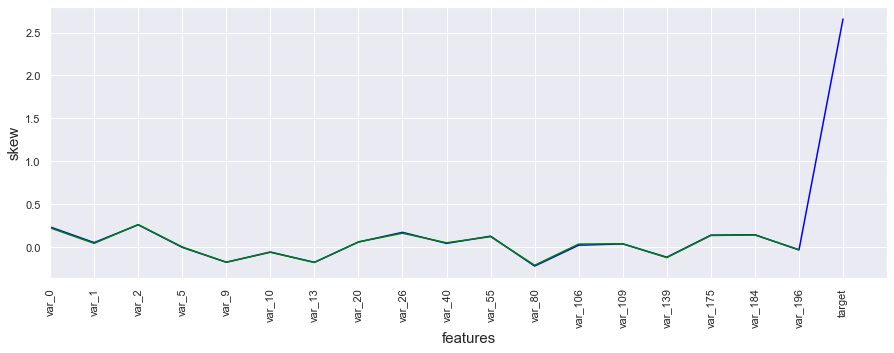

In [52]:
fig = plt.figure(figsize=(15, 5))
train_stats, test_stats = train_num_features.skew(), test_num_features.skew()
plt.plot(train_stats, color="blue", label="train")
plt.plot(test_stats, color="green", label="test")
plt.xticks(range(train_stats.shape[0]), train_stats.index, rotation=90)
plt.xlabel("features", size=15)
plt.xlim(0, len(train_stats))
plt.ylabel("skew", size=15)
plt.show()

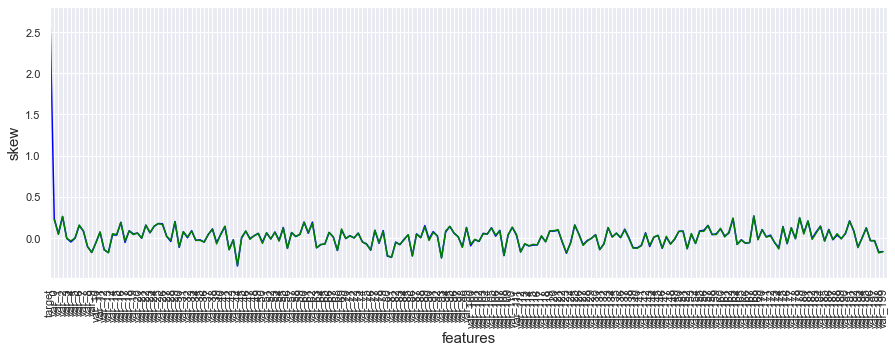

In [48]:
#train_num_features
#test_num_features
fig = plt.figure(figsize=(15, 5))
train_stats, test_stats = train.skew(), test.skew()
plt.plot(train_stats, color="blue", label="train")
plt.plot(test_stats, color="green", label="test")
plt.xticks(range(train_stats.shape[0]), train_stats.index, rotation=90)
plt.xlabel("features", size=15)
plt.xlim(0, len(train_stats))
plt.ylabel("skew", size=15)
plt.show()

## Задание 5:<a class="anchor" id="task5"></a>

Построить распределение коэффициентов корреляции между признаками. Есть ли зависимость между признаками (будем считать, что связь между признаками отсутствует, если коэффициент корреляции < 0.2)?

**Для всех признаков - связь между признаками отсутствует, коэффициент корреляции < 0.2**

In [39]:
numerical_features_1 = []
numerical_features_1

[]

In [40]:
numerical_features_1 = numerical_features
numerical_features_1.append('target')
print(numerical_features_1)

['var_0', 'var_1', 'var_2', 'var_5', 'var_9', 'var_10', 'var_13', 'var_20', 'var_26', 'var_40', 'var_55', 'var_80', 'var_106', 'var_109', 'var_139', 'var_175', 'var_184', 'var_196', 'target']


In [41]:
train_num_features = train[numerical_features_1]

correlation = train_num_features.corr()
corr_with_target = correlation["target"].sort_values(ascending = False)
corr_with_target

target     1.000000
var_26     0.062422
var_2      0.055870
var_0      0.052390
var_1      0.050343
var_40     0.049530
var_184    0.048315
var_106    0.032947
var_5      0.030979
var_196    0.023608
var_175    0.021692
var_55     0.017176
var_10    -0.002213
var_20    -0.018329
var_9     -0.042805
var_109   -0.049926
var_13    -0.055156
var_80    -0.057609
var_139   -0.074080
Name: target, dtype: float64

In [42]:
test.columns
num_features = []
#print(type(num_features))
num_features = test.columns
#print(type(num_features))
num_features

Index(['ID_code', 'var_0', 'var_1', 'var_2', 'var_3', 'var_4', 'var_5',
       'var_6', 'var_7', 'var_8',
       ...
       'var_190', 'var_191', 'var_192', 'var_193', 'var_194', 'var_195',
       'var_196', 'var_197', 'var_198', 'var_199'],
      dtype='object', length=201)

In [43]:
train_correlation = train.corr()
train_corr_with_target = train_correlation["target"].sort_values(ascending = False)
train_corr_with_target.head(11)


target     1.000000
var_6      0.066731
var_110    0.064275
var_53     0.063399
var_26     0.062422
var_22     0.060558
var_99     0.058367
var_190    0.055973
var_2      0.055870
var_133    0.054548
var_0      0.052390
Name: target, dtype: float64

In [44]:
for num, feature in enumerate(numerical_features):
    #print(f'{feature}: {train_corr_with_target[num]}')
    if train_corr_with_target[num] > 0.2:
        print(f'{feature}: {corr_with_target[num]}')

var_0: 1.0


**Вывод**: Для всех признаков - связь между признаками отсутствует, коэффициент корреляции < 0.2

**Correlation Heat Map**

<AxesSubplot:title={'center':'Correlation of Numeric Features with Sale Price'}>

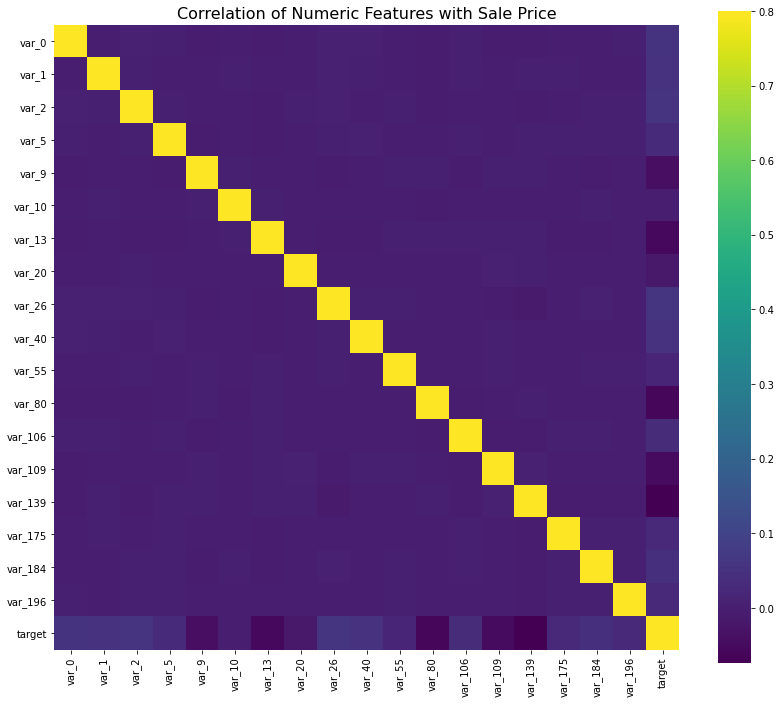

In [45]:
fig, axes = plt.subplots(figsize = (14,12))
plt.title("Correlation of Numeric Features with Sale Price", y=1, size=16)
sns.heatmap(correlation, square=True, vmax=0.8, cmap="viridis")

## Задание 6:<a class="anchor" id="task6"></a>

Выявить 10 признаков, которые обладают наибольшей нелинейной связью с целевой переменной.

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\axisgrid.py:1912: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


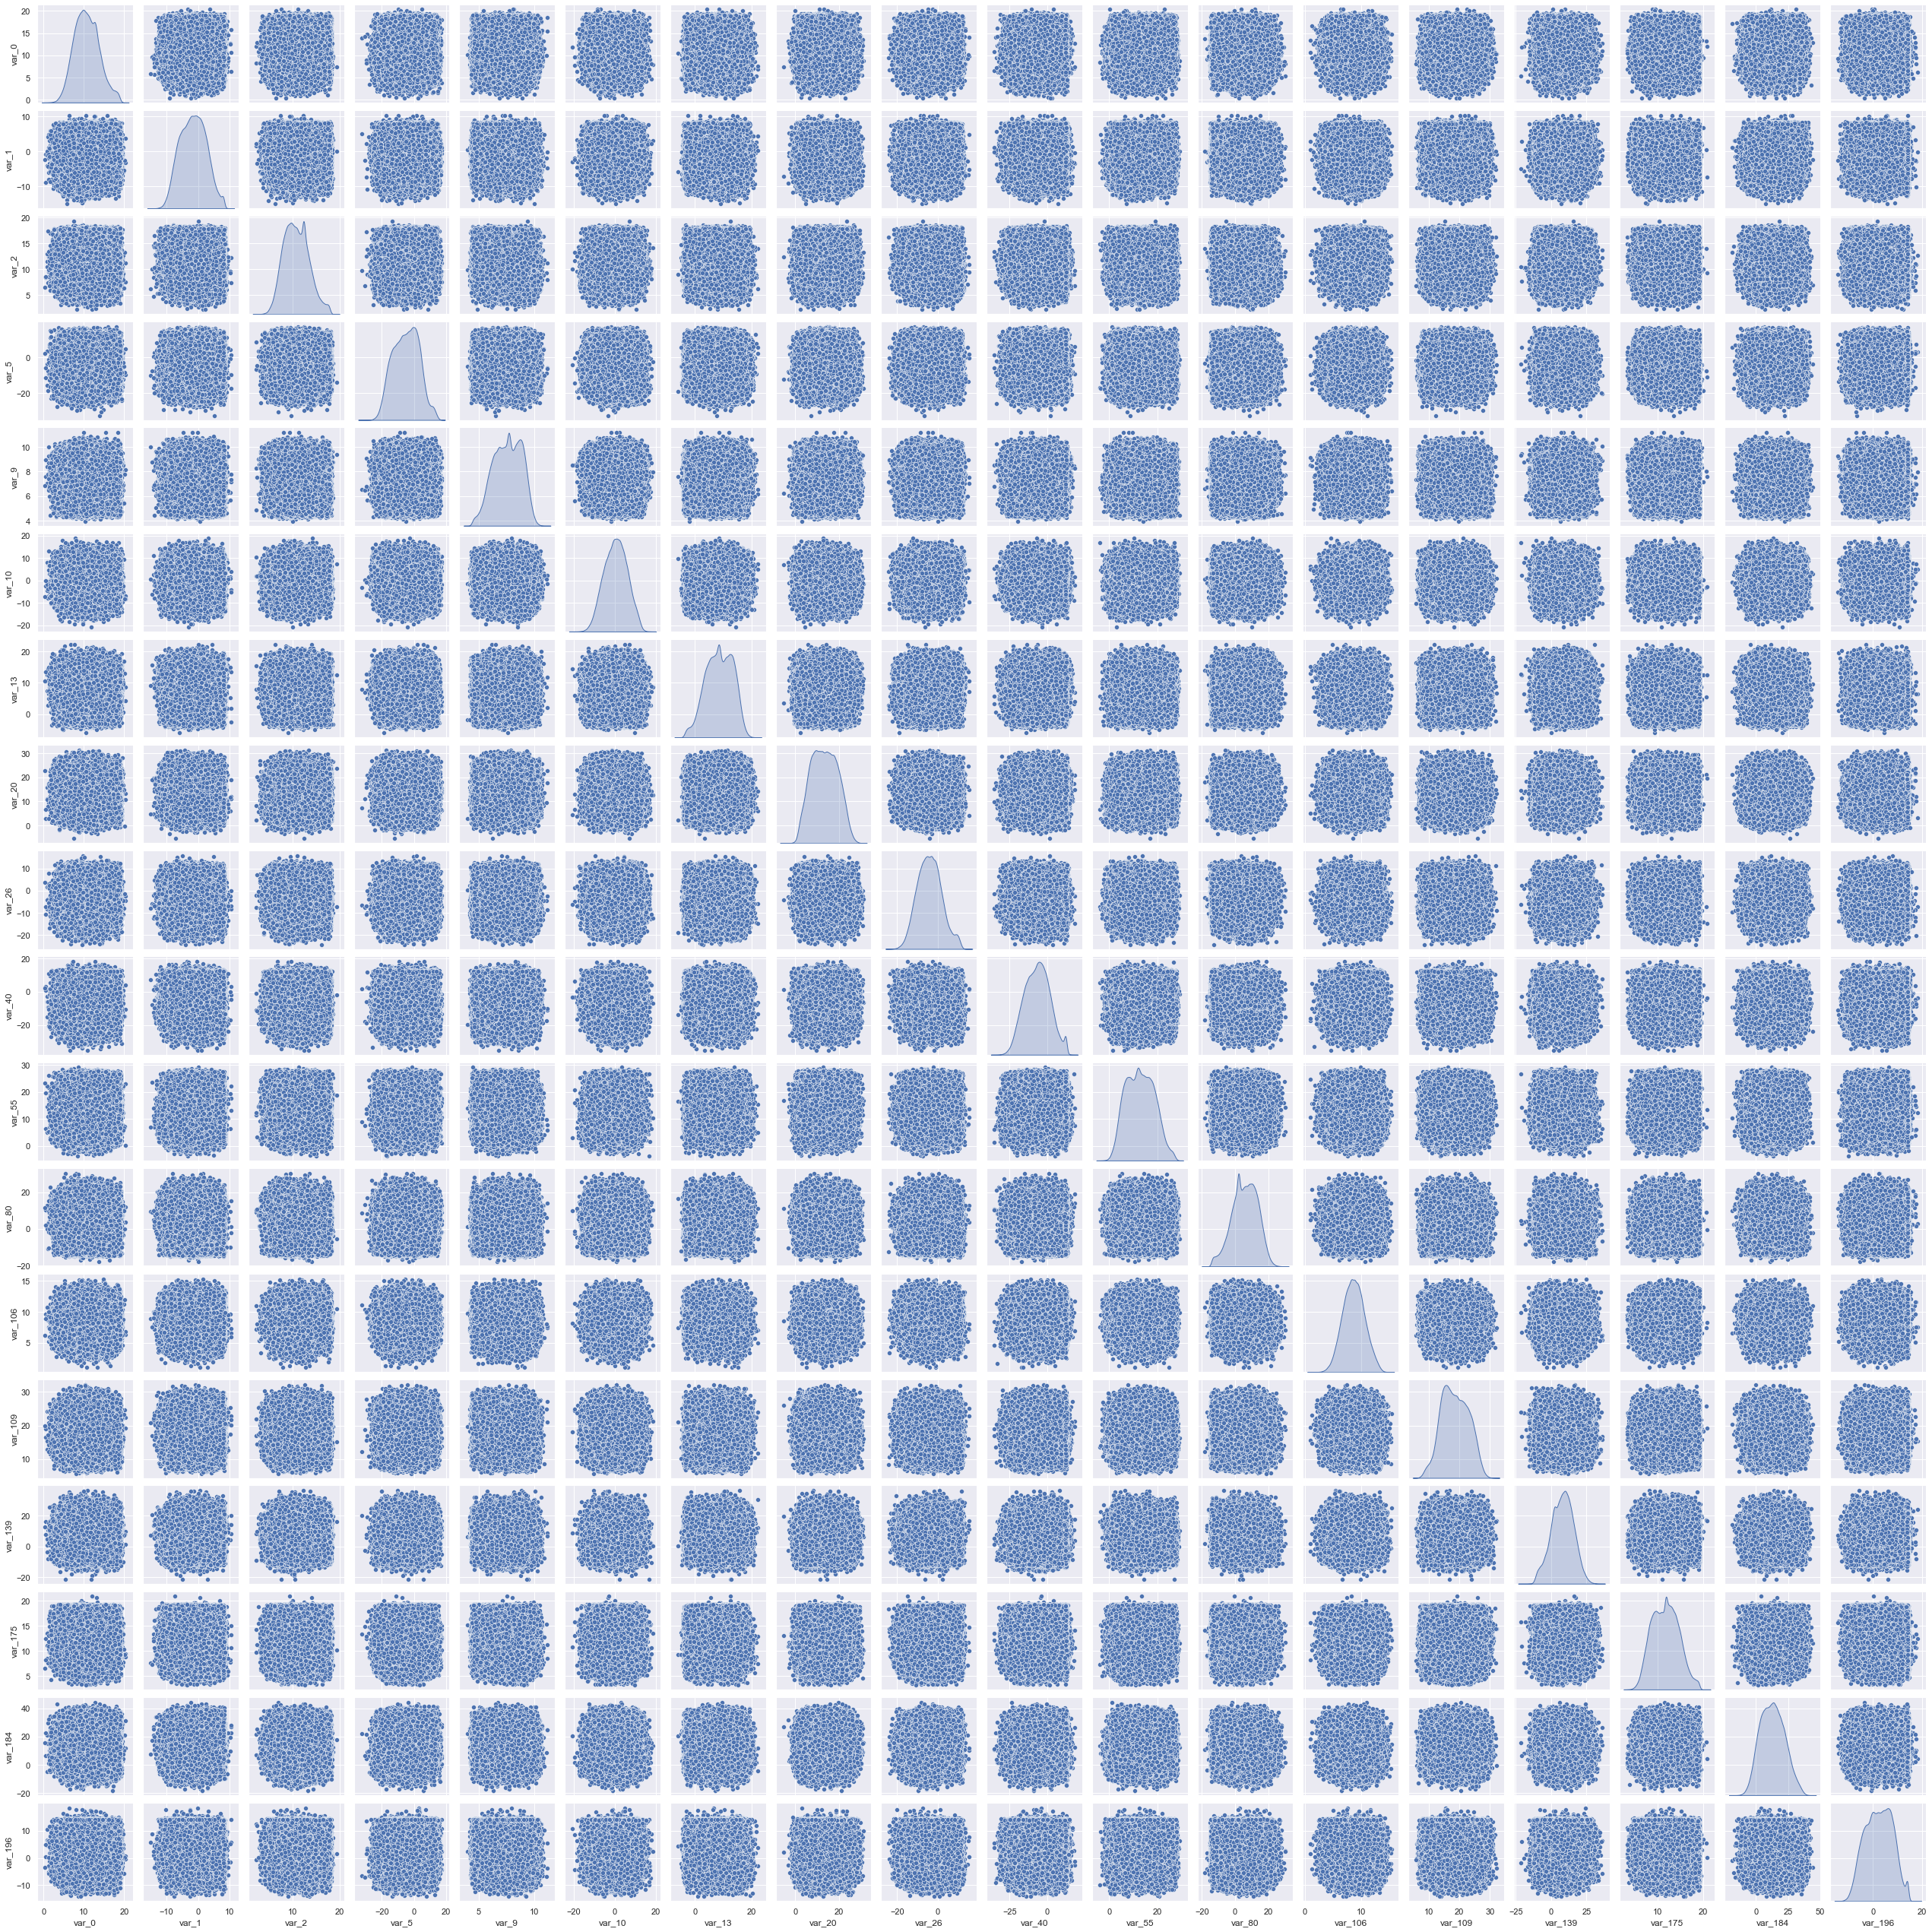

In [46]:
sns.set()
columns =  ['var_0', 'var_1', 'var_2', 'var_5', 'var_9', 'var_10', 'var_13', 'var_20', 'var_26', 'var_40',
                      'var_55', 'var_80', 'var_106', 'var_109', 'var_139', 'var_175', 'var_184', 'var_196']

sns.pairplot(train[columns], size=2, kind="scatter", diag_kind="kde")
plt.show()

## Задание 7:<a class="anchor" id="task7"></a>


Провести анализ идентичности распределения признаков на обучающей и тестовой выборках, сделать выводы.

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0, 0.5, 'Density')

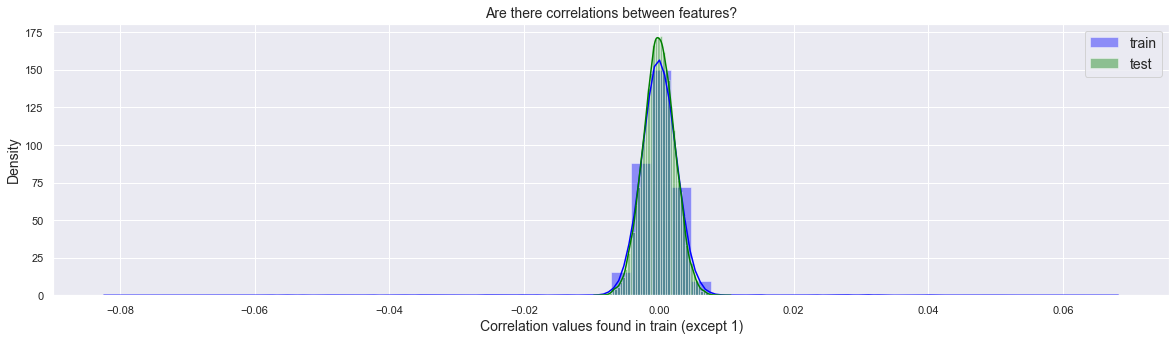

In [49]:
numerical_features = train.select_dtypes(include=[np.number])

#columns = numerical_features.columns.tolist()
#columns.remove("target")

train_correlations = numerical_features.corr()
#train_correlations = train[columns].corr()
train_correlations = train_correlations.values.flatten()
train_correlations = train_correlations[train_correlations != 1]

columns = numerical_features.columns.tolist()
columns.remove("target")

test_correlations = test[columns].corr()
test_correlations = test_correlations.values.flatten()
test_correlations = test_correlations[test_correlations != 1]

plt.figure(figsize=(20,5))
sns.distplot(train_correlations, color="Blue", label="train")
sns.distplot(test_correlations, color="Green", label="test")

plt.xlabel("Correlation values found in train (except 1)", size=14)
plt.title("Are there correlations between features?", size=14)
plt.legend(loc="best", fontsize=14)
plt.ylabel("Density", size=14)

In [51]:
%time

Wall time: 0 ns
